# A causal estimate of the price elasticity of demand

We want to estimate the causal estimate for the price elasticity of demand. We will do this by the data on fish baskets sold at the **Fulton Fish market** in New York. For causal inference, we use the Instrumental Variables (IV) approach.

## 1. Import data and libraries
Let's import the necessary Python libraries and read the publicly available data on the famous Fulton fish market. The data is present on Kathryn Graddy's [personal website](https://www.kathryngraddy.org/research#pubdata) and is already cleaned.

In [20]:
# Import relevant Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from linearmodels import IV2SLS

In [21]:
# Read the Fulton Fish market dataset
with open('Fulton_fish_market_dataset.txt') as infile:
    # Read space-delimited file and replace all empty spaces by commas
    data = infile.read().replace(' ', ',')
    # Write the CSV data in the output file
    print(data, file=open('my_file.csv', 'w'))

# Open the dataframe
df = pd.read_csv("my_file.csv", sep="\t")

## 2. Naively explore the price-quantity relationship

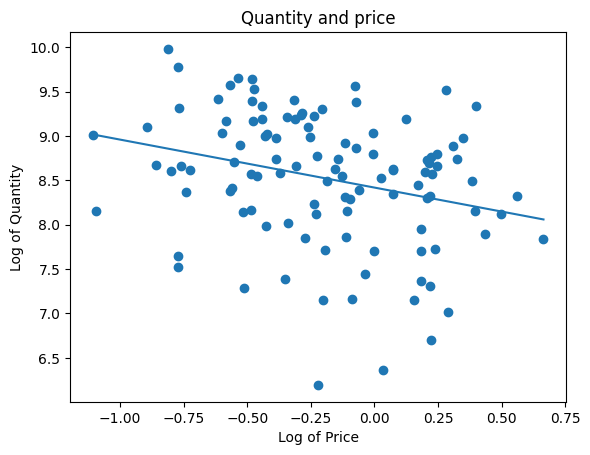

In [22]:
# Let's try to understand the price-quantity relationship
plt.scatter(df["price"], df["qty"])
plt.xlabel("Log of Price")
plt.ylabel("Log of Quantity")
plt.title("Quantity and price")
plt.plot(np.unique(df["price"]), np.poly1d(np.polyfit(df["price"], df["qty"], 1))(np.unique(df["price"])))
plt.show()

**Interpretation:** We observe a weak negative price-quantity correlation. However, currently no consideration is given to the time dimension of the data. 

<AxesSubplot: title={'center': 'Quantity and price of fish sold'}, xlabel='date1'>

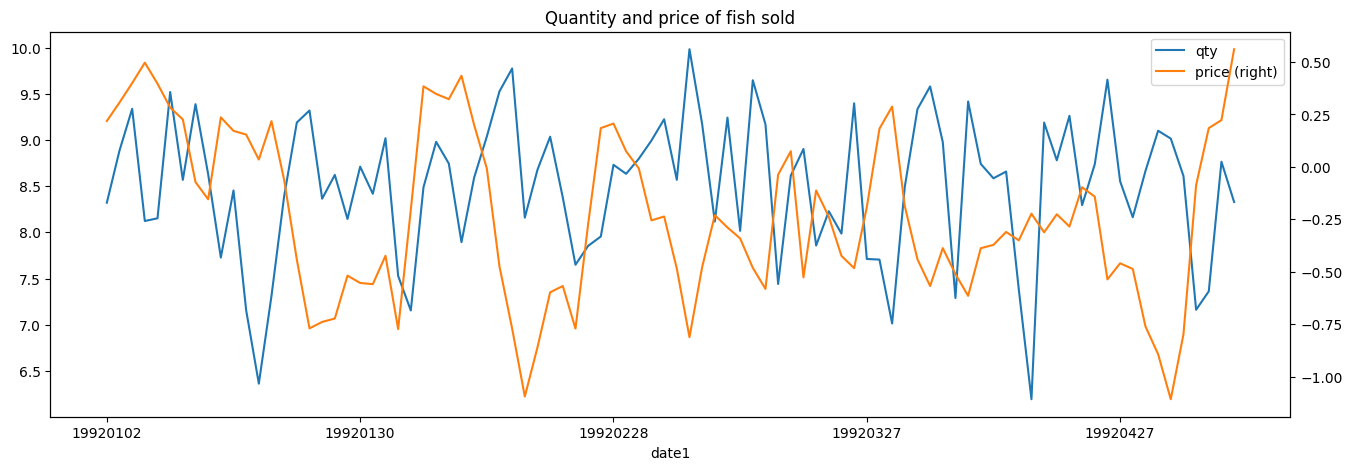

In [23]:
# Let's plot the evolution of quantity-price observations over time
# df.groupby('date').agg({'qty': 'sum', 'price': 'sum'}).plot(title='number of items sold and revenue over time', secondary_y='price',figsize=(16, 5))
# Let's skip earlier data points to get a rather smooth time series

# We will create day, month and year indicators that we will use later in the empirical investigation 
df["date1"] = df["date"].astype('str')
df['date1'] = '19' + df['date1'].astype("str")
df['year'] = df['date1'].str[0:4].astype("int32")
df['month'] = df['date1'].str[4:6].astype("int32")
df['day'] = df['date1'].str[6:8].astype("int32")
df['year'].value_counts()

# Ignore observations of 1991
df1=df.loc[df["year"]>1991] #we lose 21 observations
df1.groupby('date1').agg({'qty': 'sum', 'price': 'sum'}).plot(title='Quantity and price of fish sold', secondary_y='price',figsize=(16, 5))

The graph is not as informative as we cannot make a conclusive observation.

To be sure, lets conduct a formal investigation and estimate the price elasticity of demand.

## 3. Estimating the price elasticity of demand
### Using the ordinary least squares (OLS) method

Let's apply the Linear Regression Model and study the price-quantity relationship.
To know how the price elasticity of demand is modeled, see [here](https://github.com/sumitdeole/price_elasticity/blob/main/README.md#modeling-the-price-elasticity-of-demand).

In [24]:
# First add an intercept to our model (beta_0)
df['const'] = 1

# Fit ols and print summary
results_ols = sm.OLS(df['qty'],
                    df[['const', 'price']]).fit()
print(results_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     9.167
Date:                Tue, 13 Dec 2022   Prob (F-statistic):            0.00308
Time:                        17:20:29   Log-Likelihood:                -119.35
No. Observations:                 111   AIC:                             242.7
Df Residuals:                     109   BIC:                             248.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.4187      0.076    110.445      0.0

**Interpretation:** The negative and statistically significant (at 1%) coefficient of -0.54 on $Price$ indicates that the increases in prices are responded with reduction in the quantity demanded, i.e., the demand curve is downward sloping. Notably, the coefficient is analogus to those presented in column (1) of Table 2 in [Graddy (2006)](https://pubs.aeaweb.org/doi/pdfplus/10.1257/jep.20.2.207).

In [25]:
# Include other variables available in the dataset, except "weather on shore" as it is not clearly defined in the paper and is nor explicitly made available in the dataset provided int 
results_ols = sm.OLS(df['qty'],
                    df[['const', 'price', 'day1', 'day2', 'day3', 'day4', "rainy"]]).fit()
print(results_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     4.926
Date:                Tue, 13 Dec 2022   Prob (F-statistic):           0.000180
Time:                        17:20:30   Log-Likelihood:                -109.95
No. Observations:                 111   AIC:                             233.9
Df Residuals:                     104   BIC:                             252.9
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.5914      0.151     56.847      0.0

The result coefficients are qualitatively similar to those shown in column (2) of Table 2 in [Graddy (2006)](https://pubs.aeaweb.org/doi/pdfplus/10.1257/jep.20.2.207).

However, as noted in the [README file](https://github.com/sumitdeole/price_elasticity/blob/main/README.md#endogeneity-concerns), the price elasticity estimates shown above are biased due to many potential sources of endogeneity. We address the said endogeneity concern by applying the Instrumental Variables approach detailed [here](https://github.com/sumitdeole/price_elasticity/blob/main/README.md#the-iv-algorithm-of-causal-inference).

### Using the Instrumental Variables (IV) approach
To obtain a causal price elasticity of demand using the IV approach, we need a third variable referred to as an Instrumental Variable (IV). The IV variable is such that it is highly correlated with the endogenous regressor $Price$, but should not directly affect the quantity demanded ($Quantity$), facilitating the assessment of the causal impact of $Price$ on $Quantity$. 

**The choice of the IV**
Following Kathryn Graddy's reasoning, we consider stormy weather the IV for the endogenous regressor $Price$. We will show the first stage regression results below to support the first identifying condition of the IV, i.e., IV is correlated with $Price$. Notably, we will exclude the discussion of the "exclusion restriction" assumption from the scope of our analysis. 

The practical implementation of the IV approach takes place in two steps. 
- First, we show that the IV correlates with the endogenous regressor, the step often referred to as the *First stage*. 
#### First stage

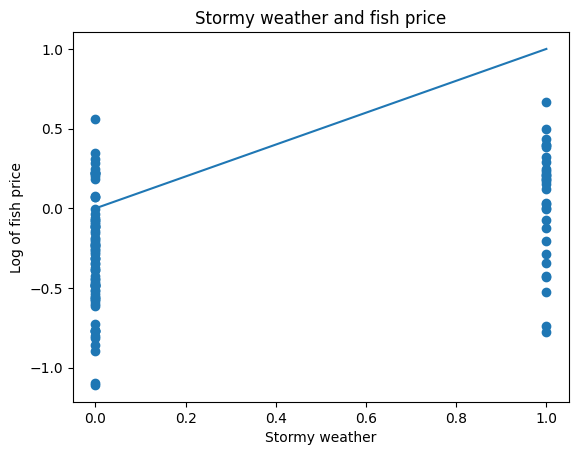

In [26]:
# Lets first visualize the first stage graphically
plt.scatter(df["stormy"], df["price"])
plt.xlabel("Stormy weather")
plt.ylabel("Log of fish price")
plt.title("Stormy weather and fish price")
plt.plot(np.unique(df["stormy"]), np.poly1d(np.polyfit(df["stormy"], df["stormy"], 1))(np.unique(df["stormy"])))
plt.show()

**Interpretation:** A broad reading of this graph suggests that the fish prices are on average higher during stormy weather.   
##### Now, lets investigate first stage more formally

In [27]:
# Now we will regress the IV on our endogenous regressor
results_fs = sm.OLS(df['price'],
                    df[['const', 'stormy']],
                    missing='drop').fit()
print(results_fs.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     20.69
Date:                Tue, 13 Dec 2022   Prob (F-statistic):           1.41e-05
Time:                        17:20:30   Log-Likelihood:                -40.516
No. Observations:                 111   AIC:                             85.03
Df Residuals:                     109   BIC:                             90.45
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2903      0.040     -7.336      0.0

**Interpretation:** We see that stormy weathers are highly correlated with the fish price (with first stage F-statistics of above 20). 

Although a mandatory requirement in economics research, the first stage regression results (incl first stage F-stats) are not provided in the sourced article [Graddy (2006)](https://pubs.aeaweb.org/doi/pdfplus/10.1257/jep.20.2.207). 

#### IV2SLS estimates
- In the second step of the IV2SLS estimation, we obtain the predicted value of the endogenous regressor and use regress it on $Quantity$ --> a step automatically performed by the software module and needs no further work from our side.  

In [28]:
# IV estimates with no additional controls
results_iv = IV2SLS(dependent=df['qty'],
            exog=df['const'],
            endog=df['price'],
            instruments=df['stormy']).fit(cov_type='unadjusted')
print(results_iv.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                    qty   R-squared:                     -0.0002
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0094
No. Observations:                 111   F-statistic:                    5.5009
Date:                Tue, Dec 13 2022   P-value (F-stat)                0.0190
Time:                        17:20:31   Distribution:                  chi2(1)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          8.3138     0.1136     73.194     0.0000      8.0912      8.5364
price         -1.0824     0.4615    -2.3454     0.01

**Interpretation:** Consistent with earlier observation, our IV estimates of the price elasticity of demand also suggest a downward sloping demand curve. The estimated coefficient of *-1.0824* is our causal price elasticity estimate of demand.

Please note that the IV estimate is analogus to those presented in column (3) of Table 2 in [Graddy (2006)](https://pubs.aeaweb.org/doi/pdfplus/10.1257/jep.20.2.207).

In [29]:
# IV estimates after including available control variables in the dataset
formula = ("qty ~ 1 + day1 + day2 + day3 + day4 + rainy + [price ~ stormy]")
mod = IV2SLS.from_formula(formula, df)
results_iv = mod.fit(cov_type="robust")
print(results_iv.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                    qty   R-squared:                      0.1348
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0848
No. Observations:                 111   F-statistic:                    24.807
Date:                Tue, Dec 13 2022   P-value (F-stat)                0.0004
Time:                        17:20:31   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      8.4816     0.1597     53.122     0.0000      8.1687      8.7946
day1          -0.0175     0.2176    -0.0803     0.93

**Interpretation:** The results are qualitatively similar to those note above, are also analogus to those presented in column (4) of Table 2 in [Graddy (2006)](https://pubs.aeaweb.org/doi/pdfplus/10.1257/jep.20.2.207).

#### Going beyond Graddy (2006)
We will include month-fixed effects and re-estimate the above regressions
- Motivation: fish supply and demand changes across months/seasons and may also intervene in the price-quantity relationship
- The survey was carried out in six months starting in december: 12.1991, 01.1992, 02.1992, 03.1992, 04.1992, 05.1992
- We will include dummies indicating each month in our model and re-estimate the results

In [30]:
# Lets create month and year dummies
# Eyeball the variables  
df["month"].value_counts()
df["year"].value_counts()

# Cross tabulate month-years and see how observations are distirbuted across months and years
month_vs_year = pd.crosstab(df['month'], [df['year']], margins='true')
month_vs_year

# Now create dummies
df = pd.get_dummies(df, columns=["month"], prefix="month", prefix_sep="_")
df = pd.get_dummies(df, columns=["year"], prefix="year", prefix_sep="_")
df

,day1,day2,day3,day4,date,stormy,mixed,price,qty,rainy,...,day,const,month_1,month_2,month_3,month_4,month_5,month_12,year_1991,year_1992
0,1,0,0,0,911202,1,0,-0.430783,8.994421,1,...,2,1,0,0,0,0,0,1,1,0
1,0,1,0,0,911203,1,0,0.000000,7.707063,0,...,3,1,0,0,0,0,0,1,1,0
2,0,0,1,0,911204,0,1,0.072321,8.350194,1,...,4,1,0,0,0,0,0,1,1,0
3,0,0,0,1,911205,1,0,0.247139,8.656955,0,...,5,1,0,0,0,0,0,1,1,0
4,0,0,0,0,911206,1,0,0.664327,7.844241,0,...,6,1,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,1,0,0,0,920504,0,0,-0.798508,8.610683,0,...,4,1,0,0,0,0,1,0,0,1
107,0,1,0,0,920505,0,1,-0.087011,7.162397,0,...,5,1,0,0,0,0,1,0,0,1
108,0,0,1,0,920506,0,1,0.184922,7.362010,0,...,6,1,0,0,0,0,1,0,0,1
109,0,0,0,1,920507,0,1,0.223143,8.764053,0,...,7,1,0,0,0,0,1,0,0,1


In [31]:
# OLS estimates after including month-fixed effects (reference month: 12.2021)
results_fs = sm.OLS(df['qty'],
                    df[['const', 'price', 'day1', 'day2', 'day3', 'day4', 'rainy', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5']],
                    missing='drop').fit()
print(results_fs.summary())

                            OLS Regression Results                            
Dep. Variable:                    qty   R-squared:                       0.248
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     2.974
Date:                Tue, 13 Dec 2022   Prob (F-statistic):            0.00189
Time:                        17:20:32   Log-Likelihood:                -107.98
No. Observations:                 111   AIC:                             240.0
Df Residuals:                      99   BIC:                             272.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.8187      0.207     42.695      0.0

**Interpretation:** We find results consistent with earlier observation. 

In [32]:
# IV estimates after including month-fixed effects (reference month: 12.2021)
formula = ("qty ~ 1 + day1 + day2 + day3 + day4 + rainy + month_1 + month_2 + month_3 + month_4 + month_5 + [price ~ stormy]")
mod = IV2SLS.from_formula(formula, df)
results_iv = mod.fit(cov_type="robust")
print(results_iv.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                    qty   R-squared:                      0.0966
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0037
No. Observations:                 111   F-statistic:                    35.555
Date:                Tue, Dec 13 2022   P-value (F-stat)                0.0002
Time:                        17:20:33   Distribution:                 chi2(11)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Intercept      8.8271     0.1736     50.835     0.0000      8.4868      9.1674
day1          -0.0894     0.2327    -0.3841     0.70

**Interpretation:** Again, we find results consistent with earlier findings and that the demand curvey is indeed negatively sloped. 